# Projeto 1 - Algoritmos Genéticos

### Base de dados:
(i) http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/

(ii) https://www.math.uwaterloo.ca/tsp/data/index.html

- Considerar as bases Symmetric traveling salesman problem (TSP)

- Desenvolver uma Algoritmo Genético com o framework DEAP

- Utilizar o template Projeto-Algoritmos-Geneticos.ipynb

(i) Investigar os resultados com diferentes operadores:

   - Cruzamento: cxPartialyMatched(), cxUniformPartialyMatched() e cxOrdered()

   - Mutação: mutShuffleIndexes() e mutFlipBit()

   - Seleção: selTournament() e selRoulette()

(ii) Formas de execução:

- Rodar 10 vezes cada combinação distinta de operadores

- Apresentar a melhor solução, média e desvio padrão das 10 rodadas   

- Utilizar pelo menos 5 bases de dados diferentes:

In [1]:
!pip install deap


[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import math
import random
import array
import numpy
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
from deap import base
from deap import creator
from deap import algorithms
from deap import tools

In [4]:
def distL2(x1,y1, x2,y2):
    """Compute the L2-norm (Euclidean) distance between two points.

    The distance is rounded to the closest integer, for compatibility
    with the TSPLIB convention.

    The two points are located on coordinates (x1,y1) and (x2,y2),
    sent as parameters"""
    xdiff = x2 - x1
    ydiff = y2 - y1
    return int(math.sqrt(xdiff*xdiff + ydiff*ydiff) + .5)

In [5]:
def distL1(x1,y1, x2,y2):
    """Compute the L1-norm (Manhattan) distance between two points.

    The distance is rounded to the closest integer, for compatibility
    with the TSPLIB convention.

    The two points are located on coordinates (x1,y1) and (x2,y2),
    sent as parameters"""
    return int(abs(x2-x1) + abs(y2-y1)+.5)

In [6]:
def calc_matriz(coord, dist):
    """Calcula a matriz de distância entre as cidades.

    Utiliza a função armazena em 'dist' para calcular as distâncias
    entre dois pontos quaisquer.

    Parametross:
    -coord -- lista de tuplas com as coordenadas de todos os pontos, [(x1,y1),...,(xn,yn)]
    -dist -- funçaõ distância
    """
    n = len(coord)
    # dicionario com as com coordenadas (chave) e distâncias (valor)
    D = {}
    for i in range(n-1):
        for j in range(i+1,n):
            (x1,y1) = coord[i]
            (x2,y2) = coord[j]
            D[i,j] = dist(x1,y1,x2,y2)
            D[j,i] = D[i,j]
    return n,D

In [7]:
def read_tsplib(filename):
    "basic function for reading a TSP problem on the TSPLIB format"
    "NOTE: only works for 2D euclidean or manhattan distances"
    f = open(filename, 'r');

    line = f.readline()
    while line.find("EDGE_WEIGHT_TYPE") == -1:
        line = f.readline()

    if line.find("EUC_2D") != -1:
        dist = distL2
    elif line.find("MAN_2D") != -1:
        dist = distL1
    else:
        print("cannot deal with non-euclidean or non-manhattan distances")
        raise Exception

    while line.find("NODE_COORD_SECTION") == -1:
        line = f.readline()

    xy_positions = []
    while 1:
        line = f.readline()
        if line.find("EOF") != -1: break
        (i,x,y) = line.split()
        # print(dist,i,x,y)
        x = float(x)
        y = float(y)
        xy_positions.append((x,y))

    n,D = calc_matriz(xy_positions, dist)
    return n, xy_positions, D

In [8]:
def custo(tour, D):
    """Calcula a distÇancia da rota de acordo com a matriz 'D'."""
    z = D[tour[-1], tour[0]]    # aresta a entre a primeira e última cidade da rota
    for i in range(1,len(tour)):
        z += D[tour[i], tour[i-1]] # atualiza o custo da rota a partir da cidade i-1 to i
    return z

In [9]:
def randtour(n):
    """Gera uma solução aleatória de tamanho 'n'."""
    sol = list(range(n)) # Gera uma lista sequencial
    random.shuffle(sol) # Embaralha a lista
    return sol


In [10]:
# Exemplo com instância "a280.tsp"
dataset = 'eil51'
path = './'+ dataset + '.tsp' 
print(path)

best_fitness_dataset = {
    'eil51' : '426',
    'st70' : '675',
    'rat99' : '1211',
    'rd100': '7910',
    'pr76': '108159',
}

n, coord, D = read_tsplib(path)
n, coord, D

./eil51.tsp


(51,
 [(37.0, 52.0),
  (49.0, 49.0),
  (52.0, 64.0),
  (20.0, 26.0),
  (40.0, 30.0),
  (21.0, 47.0),
  (17.0, 63.0),
  (31.0, 62.0),
  (52.0, 33.0),
  (51.0, 21.0),
  (42.0, 41.0),
  (31.0, 32.0),
  (5.0, 25.0),
  (12.0, 42.0),
  (36.0, 16.0),
  (52.0, 41.0),
  (27.0, 23.0),
  (17.0, 33.0),
  (13.0, 13.0),
  (57.0, 58.0),
  (62.0, 42.0),
  (42.0, 57.0),
  (16.0, 57.0),
  (8.0, 52.0),
  (7.0, 38.0),
  (27.0, 68.0),
  (30.0, 48.0),
  (43.0, 67.0),
  (58.0, 48.0),
  (58.0, 27.0),
  (37.0, 69.0),
  (38.0, 46.0),
  (46.0, 10.0),
  (61.0, 33.0),
  (62.0, 63.0),
  (63.0, 69.0),
  (32.0, 22.0),
  (45.0, 35.0),
  (59.0, 15.0),
  (5.0, 6.0),
  (10.0, 17.0),
  (21.0, 10.0),
  (5.0, 64.0),
  (30.0, 15.0),
  (39.0, 10.0),
  (32.0, 39.0),
  (25.0, 32.0),
  (25.0, 55.0),
  (48.0, 28.0),
  (56.0, 37.0),
  (30.0, 40.0)],
 {(0, 1): 12,
  (1, 0): 12,
  (0, 2): 19,
  (2, 0): 19,
  (0, 3): 31,
  (3, 0): 31,
  (0, 4): 22,
  (4, 0): 22,
  (0, 5): 17,
  (5, 0): 17,
  (0, 6): 23,
  (6, 0): 23,
  (0, 7): 12,
  

In [11]:
""" Registro dos operadores de combinação
    -toolbox -- caixa de ferramentas do DEAP
    -v_indpb -- probabilidade de mutação
"""
def cx_partialy_matched(toolbox, v_indpb = 0.01):
    toolbox.register("mate", tools.cxUniformPartialyMatched, indpb = v_indpb)

""" Registro dos operadores de combinação
    -toolbox -- caixa de ferramentas do DEAP
"""
def cx_uniform_partialy_matched(toolbox):
    toolbox.register("mate", tools.cxPartialyMatched)

""" Registro dos operadores de combinação
    -toolbox -- caixa de ferramentas do DEAP
"""
def cx_ordered(toolbox):
    toolbox.register("mate", tools.cxOrdered)

In [12]:
""" Registro dos operadores de mutação
    -toolbox -- caixa de ferramentas do DEAP
    -v_indpb -- probabilidade de mutação
"""
def mut_shuffle_indexes(toolbox, v_indpb = 0.01 ):
    toolbox.register("mutate", tools.mutShuffleIndexes, indpb = v_indpb)

In [13]:
""" Registro dos operadores de seleção
    -toolbox -- caixa de ferramentas do DEAP
    -v_tournsize -- tamanho do torneio
"""
def sel_tournament(toolbox, v_tournsize = 4):
    toolbox.register("select", tools.selTournament, tournsize = v_tournsize)

""" Registro dos operadores de seleção
    -toolbox -- caixa de ferramentas do DEAP
"""
def sel_toulette(toolbox):
    toolbox.register("select", tools.selRoulette)


In [14]:
def eval(individual):
    """Função de avaliação.
    """
    return (custo(individual, D),)

In [15]:
def create_individual(n):
    """Função que cria um indivíduo.
    """
    return creator.Individual(randtour(n))

In [16]:
def create_fitness():
    """Função que cria o tipo de função fitness.
    """
    # Cria o tipo de função fitness
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,)) # minimizar = peso negativo 
    creator.create("Individual", list, fitness=creator.FitnessMin)

In [17]:
# Cria a toolbox
def create_toolbox():
    """Função que cria a toolbox do DEAP.
    """
    toolbox = base.Toolbox()

    # Registra o gene e a função de criação 
    toolbox.register("gene", create_individual, n)

    # Registra a populacao na toolbox
    toolbox.register("population", tools.initRepeat, list, toolbox.gene)

    # Registra o evaluate na toolbox
    toolbox.register("evaluate", eval)
    
    return toolbox

In [18]:
def test_register(toolbox):
    # Testando os registros
    pop = []
    pop.append(toolbox.gene())
    
    # pop = toolbox.population(n=10)
    fitValue = list(map(toolbox.evaluate,pop))
    print(f'{pop[0]}: {fitValue}')

In [19]:
def statistics(individual):
    return individual.fitness.values

In [20]:

def run_GA(toolbox, 
           prob_cross, 
           prob_mut,
           halloffame,
           generations,
           population_n = 400,
           v_verbose = True):
    """Executa o algoritmo genético.
    
    Parâmetros:
    -toolbox -- caixa de ferramentas do DEAP
    -prob_cross -- probabilidade de cruzamento
    -prob_mut -- probabilidade de mutação
    -halloffame -- objeto do DEAP que armazena o melhor indivíduo encontrado
    -geracoes -- número de gerações
    -population_n -- tamanho da população
    -verbose -- se True, imprime informações sobre a execução do algoritmo
    
    """
    population = toolbox.population(n = population_n)
    
    stats = tools.Statistics(statistics)
    
    stats.register("min", numpy.min)
    stats.register("avg", numpy.mean)
    stats.register("std", numpy.std)

    population, info = algorithms.eaSimple(population, 
                                               toolbox,
                                               prob_cross,
                                               prob_mut,
                                               generations, 
                                               stats,
                                               halloffame,
                                               verbose = v_verbose)

    return min(info, key=lambda x: (x['min']))


In [21]:
def plot_TSP(individual, names ,n):
    """Visualizar o melhor caminho encontrado pelo algoritmo genético.
    
    Parâmetros:
    -individual -- melhor indivíduo encontrado pelo algoritmo genético
    -names -- nomes dos operadores genéticos utilizados
    -n -- número da figura
    """
    plt.figure(n)
    plt.title(names[n])
    plt.scatter(*zip(*coord), marker='.', color='red')
    locs = [coord[i] for i in individual]
    locs.append(locs[0])
    plt.plot(*zip(*locs), linestyle='-', color='blue')
    plt.text(-4, -12, f'caminho: {individual}, custo: {custo(individual, D)}', fontsize=12, wrap=True, verticalalignment='top')


In [22]:
def run_operators(prob_cross, prob_mut, generations, crossover, mutation, selection):
    """Executa o algoritmo genético para uma série de execuções (10 no caso), usando diferentes combinações de operadores genéticos (cruzamento, mutação e seleção)
    
    Paramentros: 
    -prob_cross -- probabilidade de cruzamento
    -prob_mut -- probabilidade de mutação
    -generations -- número de gerações
    -crossover -- função de cruzamento
    -mutation -- função de mutação
    -selection -- função de seleção
    """

    best_fit = []
    
    halloffame = tools.HallOfFame(1) # armazena o melhor indivíduo encontrado durante a execução do algoritmo genético
    
    for _ in range(10):
        toolbox = create_toolbox()
        selection(toolbox)
        crossover(toolbox)
        mutation(toolbox)
        #test_register(toolbox)
        best = run_GA(toolbox, prob_cross, prob_mut, halloffame, generations) #executa o algoritmo genético usando a toolbox configurada e os parâmetros fornecidos
        best_fit.append(best) #Adiciona o melhor indivíduo encontrado à lista best_fit
                    
    return min(best_fit, key=lambda x: (x['min'])), halloffame[0]

In [33]:
#Parametros de execução dos Operadores Genéticos e Avaliação do Desempenho
prob_cross = 0.95
prob_mut = 0.3
generations = 500

create_fitness()

crossover_functions = [cx_ordered,cx_partialy_matched, cx_uniform_partialy_matched]
mutation_functions = [mut_shuffle_indexes]
selection_functions = [sel_tournament, sel_toulette]

best_record = []
best_path = []
collumn_names = []

#Loop para Testar Diferentes Combinações de Operadores Genéticos
for crossover in crossover_functions:
    for mutation in mutation_functions:
        for selection in selection_functions:
            collumn_names.append(f'{crossover.__name__}/{mutation.__name__}/{selection.__name__}')
            record, path = run_operators(prob_cross, prob_mut, generations, crossover, mutation, selection)
            best_record.append(record)
            best_path.append(path)
            

gen	nevals	min 	avg   	std    
0  	400   	1429	1655.7	87.0097
1  	380   	1400	1576.6	79.7865
2  	386   	1295	1520.1	81.5369
3  	384   	1247	1471.21	76.1598
4  	376   	1167	1435.84	78.726 
5  	391   	1169	1399.51	74.8022
6  	383   	1163	1370.73	75.9113
7  	383   	1143	1343.01	76.7773
8  	380   	1117	1318.22	79.9598
9  	386   	1109	1285.87	72.7492
10 	390   	1084	1266.96	66.893 
11 	389   	1056	1257.01	76.1689
12 	382   	997 	1230.91	77.71  
13 	386   	1011	1202.95	71.9988
14 	387   	998 	1184.31	70.1613
15 	383   	982 	1164.37	69.6677
16 	387   	993 	1150.89	74.1509
17 	375   	953 	1136.77	66.1064
18 	390   	945 	1130.44	67.874 
19 	381   	921 	1124.24	70.8075
20 	383   	923 	1106.82	70.9851
21 	387   	892 	1095.9 	73.6804
22 	393   	892 	1082.43	68.3703
23 	388   	861 	1072.08	72.5708
24 	377   	884 	1064.66	76.3296
25 	384   	843 	1054.17	71.2834
26 	394   	871 	1049.46	71.6615
27 	382   	875 	1040.29	69.818 
28 	390   	867 	1034.11	71.6757
29 	386   	848 	1026.17	73.0471
30 	384   	8

### Resultados de melhor solução, média e desvio padrão de cada combinação de operadores

In [34]:
print("[TSPLIB] Melhor solução global do dataset: " + best_fitness_dataset[dataset])

[TSPLIB] Melhor solução global do dataset: 426


In [35]:
#Tabela da execução do algoritmo genético para diferentes combinações de operadores genéticos, armazenando as métricas de desempenho em um DataFrame.
dt = pd.DataFrame(best_record).T
dt.columns = collumn_names
print(dt.loc[['min','avg','std']])

     cx_ordered/mut_shuffle_indexes/sel_tournament  \
min                                     443.000000   
avg                                     462.287500   
std                                      45.501811   

     cx_ordered/mut_shuffle_indexes/sel_toulette  \
min                                  1215.000000   
avg                                  1660.102500   
std                                    92.592127   

     cx_partialy_matched/mut_shuffle_indexes/sel_tournament  \
min                                         582.000000        
avg                                         601.377500        
std                                          54.876589        

     cx_partialy_matched/mut_shuffle_indexes/sel_toulette  \
min                                         1238.00000      
avg                                         1683.96250      
std                                           93.28047      

     cx_uniform_partialy_matched/mut_shuffle_indexes/sel_tournament  \
min  

### Caminhos das melhores soluções de cada combinação de operadores

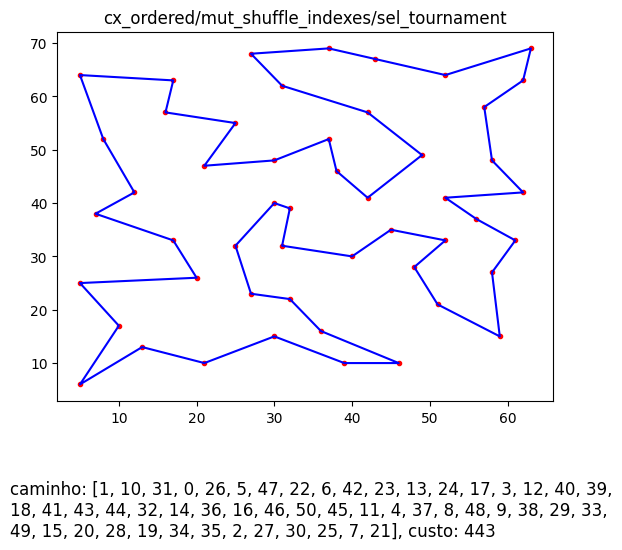

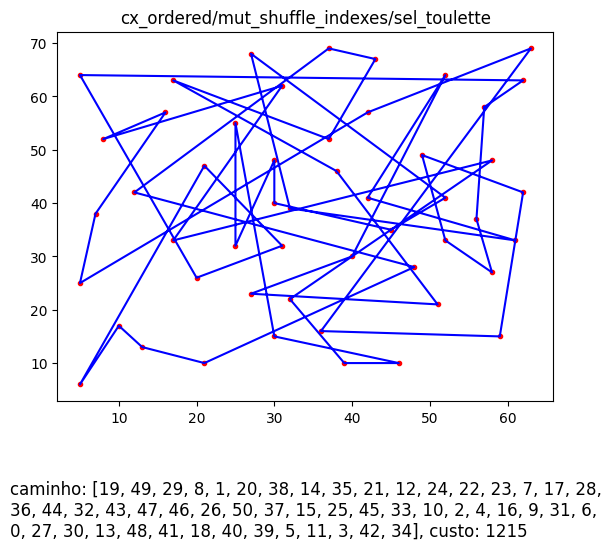

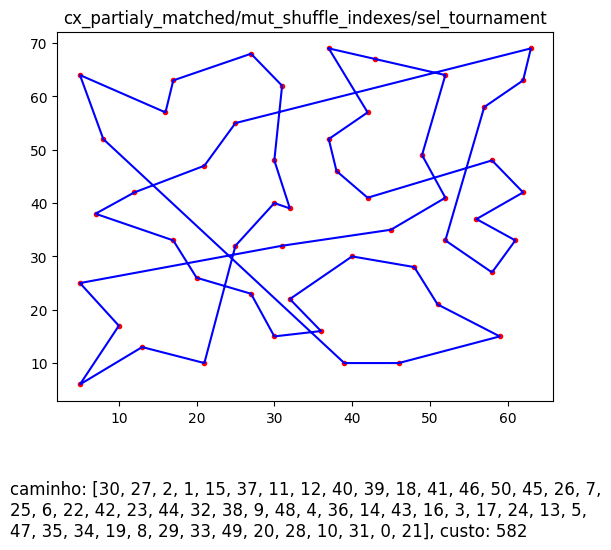

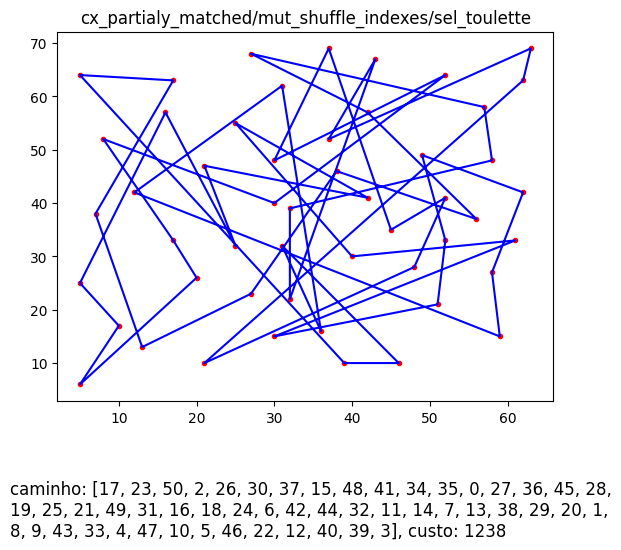

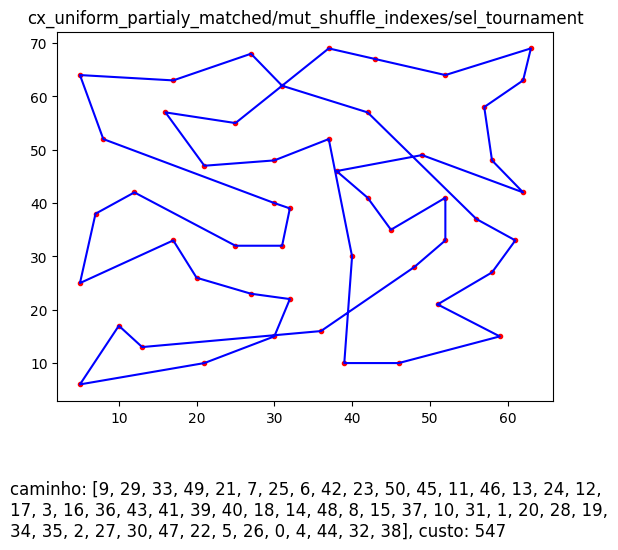

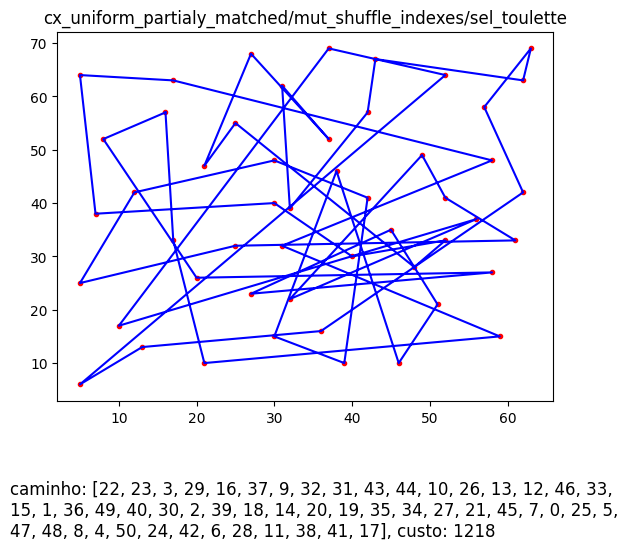

In [36]:
#visualizações das rotas encontradas pelo algoritmo genético para diferentes combinações de operadores genéticos
for i in range(len(best_path)):
    plot_TSP(best_path[i], collumn_names, i)